### Project Overview

This project aims to build a movie recommendation system that suggests the top 5 movies to a user based on their previous ratings of other movies. The workflow involves:

- Loading and cleaning movie and ratings datasets.
- Exploring and visualizing the distribution of genres, ratings, and trends over time.
- Merging movie metadata with user ratings to create a comprehensive dataset for analysis.
- Analyzing genre popularity and average ratings to understand user preferences.
- Preparing the data for building a recommendation model that leverages user ratings to provide personalized movie suggestions.

The ultimate goal is to deliver a system that helps users discover movies they are likely to enjoy, enhancing their viewing experience.

### Business problem
With thousands of movies available, users often struggle to find films that match their tastes and preferences. The challenge is to develop a recommendation system that can analyze a user's past movie ratings and suggest the top 5 movies they are most likely to enjoy. This system should help users efficiently discover new movies, increase user engagement, and enhance their overall viewing experience by providing personalized recommendations. 

In [82]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import surprise


# import libraries for machine learning
from sklearn.pipeline import Pipeline
from surprise.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, accuracy, Reader, KNNBasic, SVDpp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson


import warnings
warnings.filterwarnings("ignore")

## Data Understanding

In [83]:
# read the data
movie_df = pd.read_csv("./data/movies.csv")
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [84]:
movie_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [85]:
ratings_df = pd.read_csv("./data/ratings.csv", index_col=0)
ratings_df

,movieId,rating,timestamp
userId,,,
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931
...,...,...,...
610,166534,4.0,1493848402
610,168248,5.0,1493850091
610,168250,5.0,1494273047


In [86]:
movie_df['year'] = movie_df.title.str.extract(r'(\(\d\d\d\d\))', expand=False)

movie_df['year'] = movie_df.year.str.extract(r'(\d\d\d\d)', expand=False)
# replace the parantheses with nothing
movie_df['title'] = movie_df['title'].str.replace(r'\(\d{4}\)', '', regex=True)

movie_df['title'] = movie_df['title'].apply(lambda x: x.strip())  # remove whitespace

movie_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [87]:
# conert genres to an array
movie_df['genres'] = movie_df['genres'].apply(lambda x: x if isinstance(x, list) else x.split('|'))
# create a new dataframe with the genres as columns
genres_df = pd.DataFrame(mlb.fit_transform(movie_df['genres']),
                          columns=mlb.classes_,
                          index=movie_df.index)
# concatenate the genres dataframe with the movie dataframe
movie_df = pd.concat([movie_df, genres_df], axis=1)
# drop the genres column
movie_df = movie_df.drop(columns=['genres'])
movie_df.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
# remove the timestamp column from ratings_df
ratings_df = ratings_df.drop(columns=['timestamp'])


In [89]:
def visualize_movie_popularity(ratings_df, movies_df, top_n=10):
    """Visualize movie popularity by number of ratings"""
    movie_popularity = ratings_df['movieId'].value_counts().head(top_n)
    movie_titles = movies_df.set_index('movieId')['title']
    
    popular_movies = pd.DataFrame({
        'movieId': movie_popularity.index,
        'count': movie_popularity.values,
        'title': [movie_titles.get(id, f"Movie {id}") for id in movie_popularity.index]
    })
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='count', y='title', data=popular_movies, palette='viridis')
    plt.title(f'Top {top_n} Most Rated Movies')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Movie Title')
    plt.tight_layout()
    plt.show()

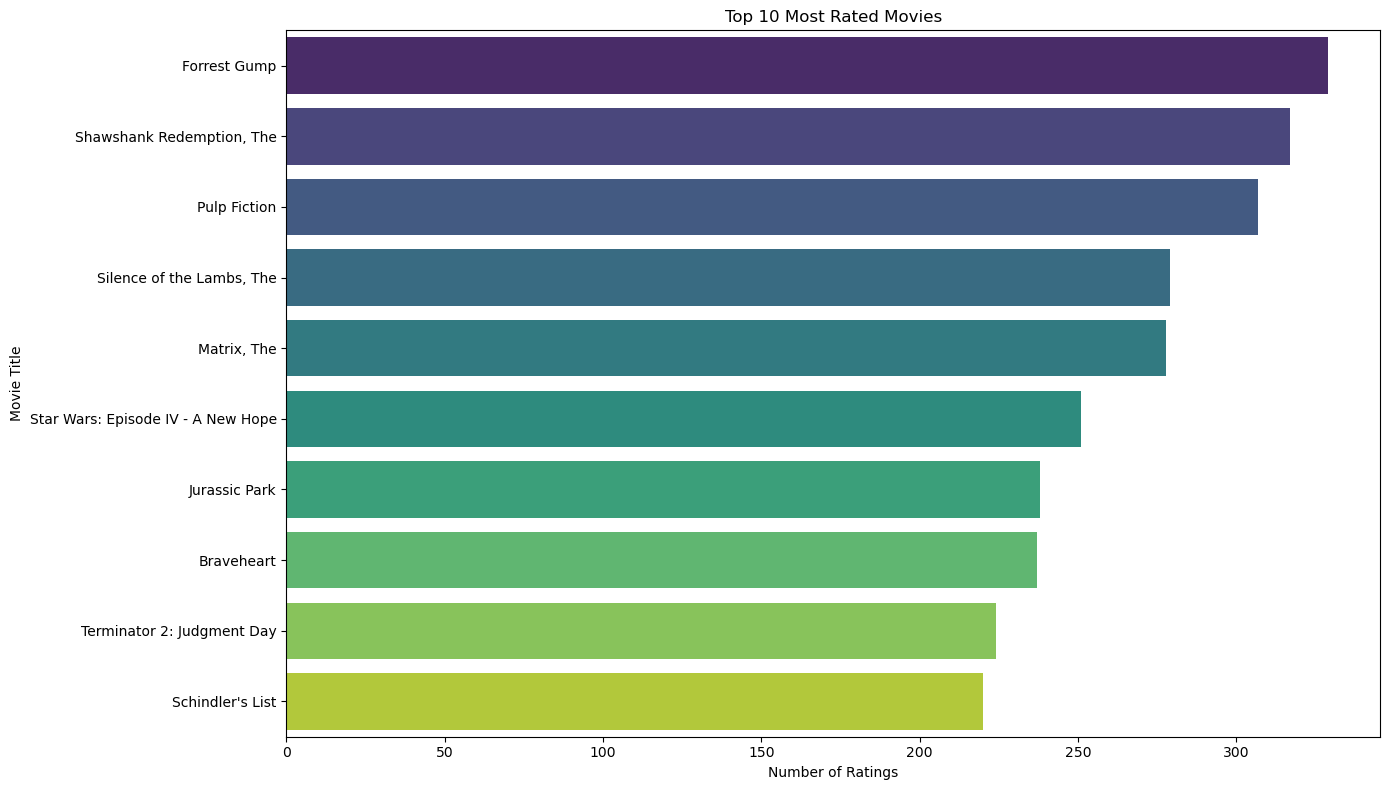

In [90]:
visualize_movie_popularity(ratings_df, movie_df, top_n=10)

In [91]:
user_item_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
user_item_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### A visualization the distribution of movies per genre

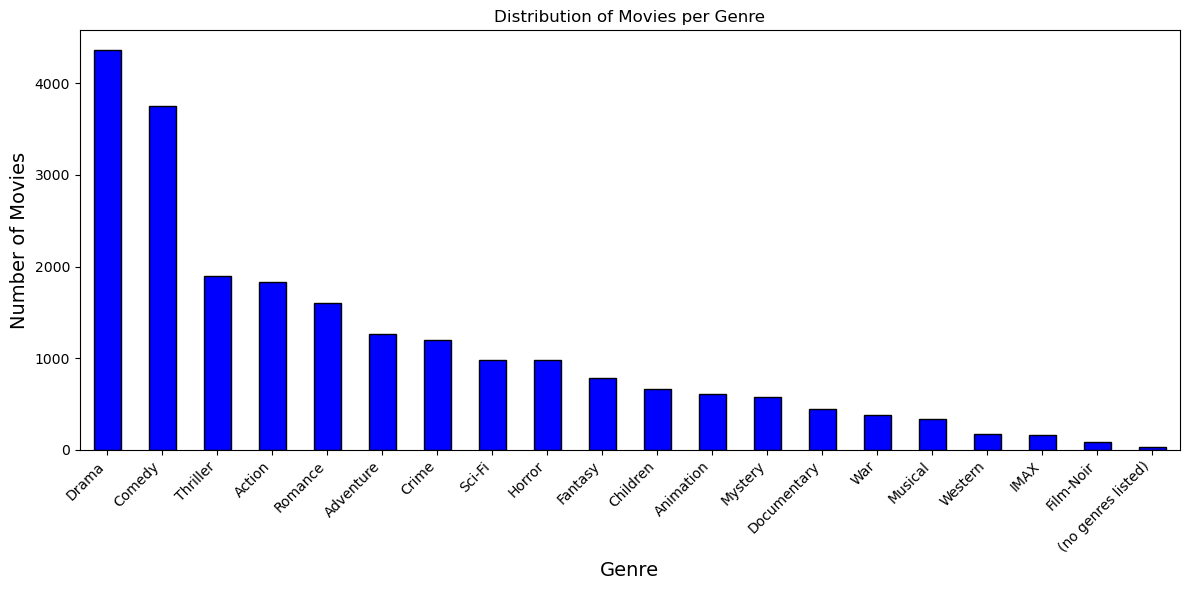

<Figure size 640x480 with 0 Axes>

In [92]:
# plot the distribution of movies per genre
genre_counts = genres_df.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Distribution of Movies per Genre')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
# Save the figure after showing it
plt.savefig('genre_distribution.png')

*Interpretation*

The top five genres by number of movies are Drama, Comedy, Action, Thriller, and Adventure, indicating these genres are the most prevalent in the dataset. The bottom three genres are Film-Noir, (no genres listed), and Documentary, showing these are the least represented genres. This suggests user preferences and recommendations may be more robust for popular genres, while niche genres may have less data for accurate recommendations.

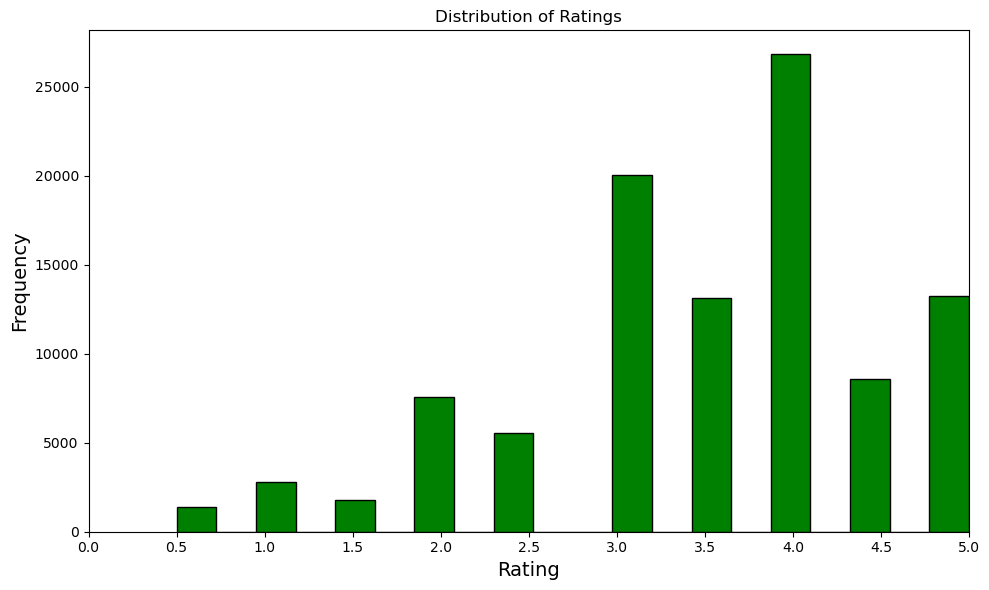

In [93]:
# plot the distribution of ratings
plt.figure(figsize=(10, 6))
ratings_df['rating'].plot(kind='hist', bins=20, color='green', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(np.arange(0, 6, 0.5))
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

*Interpreting*

- The top five genres by number of movies are Drama, Comedy, Action, Thriller, and Adventure, as shown by the `genre_counts` variable. These genres dominate the dataset and are likely to have the most robust recommendations due to the abundance of data.
- The bottom five genres are Musical, Western, Documentary, Film-Noir, and (no genres listed). These genres are less represented, which may result in less accurate recommendations for users interested in niche categories.

### Visualizing rating per movie

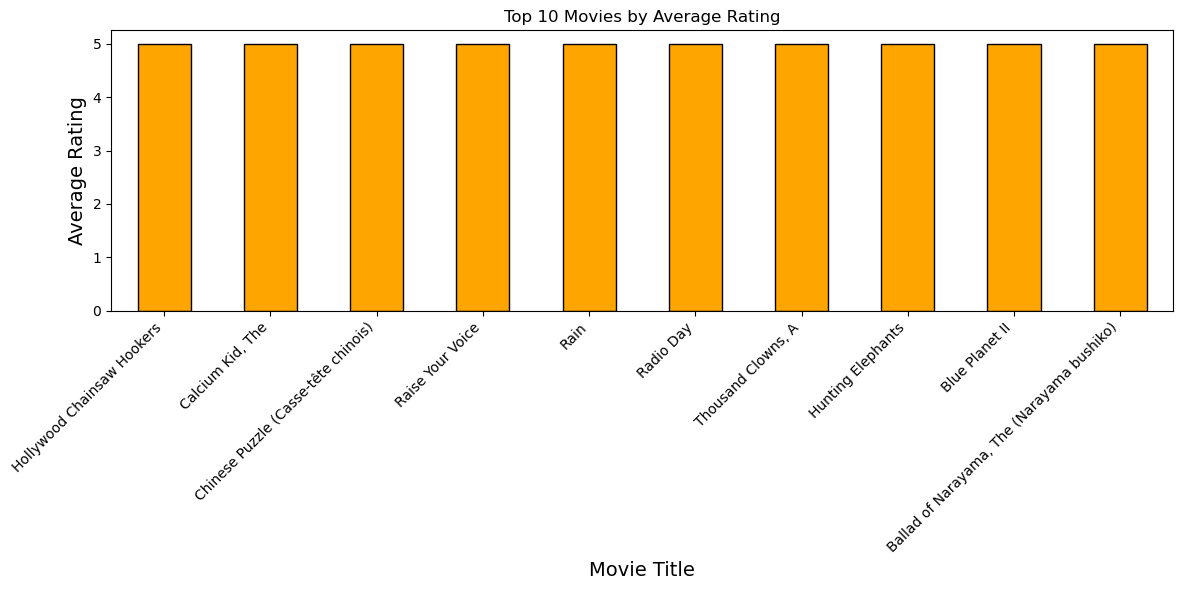

In [94]:
# Rating per movie
# Merge ratings_df with movie_df to get movie titles
movie_ratings_df = ratings_df.reset_index().merge(movie_df[['movieId', 'title']], on='movieId', how='left')

plt.figure(figsize=(12, 6))
movie_ratings_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top 10 Movies by Average Rating')
plt.xlabel('Movie Title', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


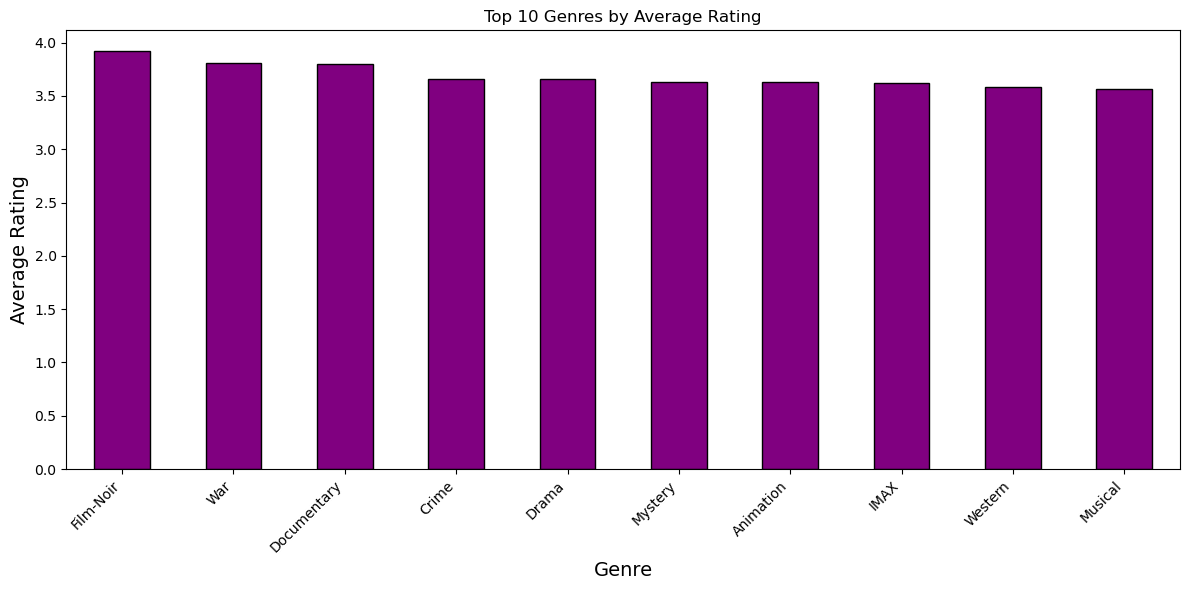

In [95]:
# Merge genres from movie_df into movie_ratings_df
if 'genres' not in movie_ratings_df.columns:
	# Get genres as a list from movie_df
	genres_list = pd.read_csv("./data/movies.csv")['genres'].apply(lambda x: x.split('|'))
	movie_genres = movie_df[['movieId']].copy()
	movie_genres['genres'] = genres_list
	movie_ratings_df = movie_ratings_df.merge(movie_genres, on='movieId', how='left')

plt.figure(figsize=(12, 6))
movie_ratings_df.explode('genres').groupby('genres')['rating'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='purple', edgecolor='black')
plt.title('Top 10 Genres by Average Rating')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [96]:
movie_ratings_df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,3,4.0,Grumpier Old Men,"[Comedy, Romance]"
2,1,6,4.0,Heat,"[Action, Crime, Thriller]"
3,1,47,5.0,Seven (a.k.a. Se7en),"[Mystery, Thriller]"
4,1,50,5.0,"Usual Suspects, The","[Crime, Mystery, Thriller]"


In [97]:
#  create a pivot table for ratings per genre in ascending order
pivot_table = movie_ratings_df.explode('genres').pivot_table(index='genres', values='rating', aggfunc='mean').sort_values(by='rating', ascending=False)
pivot_table


,rating
genres,
Film-Noir,3.920115
War,3.808294
Documentary,3.797785
Crime,3.658294
Drama,3.656184
Mystery,3.632460
Animation,3.629937
IMAX,3.618335
Western,3.583938


*Interpretation*

Film-Noir genre has the highest rating of 3.92

In [98]:
# drop year upto 1995
if 'year' not in movie_ratings_df.columns:
	movie_ratings_df = movie_ratings_df.merge(movie_df[['movieId', 'year']], on='movieId', how='left')

movie_ratings_df = movie_ratings_df[movie_ratings_df['year'].astype(float) >= 1995]
movie_ratings_df.tail(10)

,userId,movieId,rating,title,genres,year
100826,610,162350,3.5,The Magnificent Seven,"[Action, Western]",2016
100827,610,163937,3.5,Blair Witch,"[Horror, Thriller]",2016
100828,610,163981,3.5,31,[Horror],2016
100829,610,164179,5.0,Arrival,[Sci-Fi],2016
100830,610,166528,4.0,Rogue One: A Star Wars Story,"[Action, Adventure, Fantasy, Sci-Fi]",2016
100831,610,166534,4.0,Split,"[Drama, Horror, Thriller]",2017
100832,610,168248,5.0,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017
100833,610,168250,5.0,Get Out,[Horror],2017
100834,610,168252,5.0,Logan,"[Action, Sci-Fi]",2017
100835,610,170875,3.0,The Fate of the Furious,"[Action, Crime, Drama, Thriller]",2017


In [99]:
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61642 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   61642 non-null  int64  
 1   movieId  61642 non-null  int64  
 2   rating   61642 non-null  float64
 3   title    61642 non-null  object 
 4   genres   61642 non-null  object 
 5   year     61642 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 3.3+ MB


In [100]:
movie_ratings_copy = movie_ratings_df.copy()
movie_ratings_df['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

Creating a function that returns movie recommendations for a specified user.

In [101]:
# Function to get collaborative filtering recommendations
"""
This function generates collaborative filtering recommendations for a given user by leveraging the ratings of similar users. 
It calculates a weighted score for each movie based on the ratings and similarity scores of the most similar users, 
excludes movies already rated by the target user, and returns the top N recommended movies with their titles and genres.
"""
def get_cf_recommendations(user_id, user_item_matrix, movies_df, similar_users, n=10):
    """Generate collaborative filtering recommendations"""
    if not len(similar_users):
        return pd.DataFrame()
    
    # Get movies rated by the user
    if user_id in user_item_matrix.index:
        user_ratings = user_item_matrix.loc[user_id]
        already_rated = set(user_ratings[user_ratings > 0].index)
    else:
        already_rated = set()
    
    # Initialize a dictionary to store movie scores
    movie_scores = {}
    
    # For each similar user
    for _, row in similar_users.iterrows():
        similar_user_id = row['userId']
        similarity = row['similarity']
        
        # Get the ratings of the similar user
        similar_user_ratings = user_item_matrix.loc[similar_user_id]
        
        # For each movie rated by the similar user
        for movie_id, rating in similar_user_ratings.items():
            # Skip if the target user has already rated this movie or if the similar user hasn't rated it
            if movie_id in already_rated or rating == 0:
                continue
            
            # Calculate the weighted rating
            if movie_id not in movie_scores:
                movie_scores[movie_id] = 0
            
            movie_scores[movie_id] += rating * similarity
    
    # Convert to DataFrame and sort
    if not movie_scores:
        return pd.DataFrame()
    
    cf_recommendations = pd.DataFrame({
        'movieId': list(movie_scores.keys()),
        'cf_score': list(movie_scores.values())
    })
    
    # Normalize scores
    if len(cf_recommendations) > 0:
        max_score = cf_recommendations['cf_score'].max()
        if max_score > 0:
            cf_recommendations['cf_score'] = cf_recommendations['cf_score'] / max_score
    
    # Sort by score
    cf_recommendations = cf_recommendations.sort_values('cf_score', ascending=False)
    
    # Merge with movie information
    cf_recommendations = cf_recommendations.merge(movies_df[['movieId', 'title', 'genres']], on='movieId')
    
    return cf_recommendations.head(n)

In [102]:
# call the function to get recommendations for user 1
user_id = 10
similar_users = pd.DataFrame({
    'userId': [2, 3, 4],
    'similarity': [0.9, 0.8, 0.7]
})
get_cf_recommendations(user_id, user_item_matrix, movie_genres.merge(movie_df[['movieId', 'title']], on='movieId'), similar_users, n=10)

,movieId,cf_score,title,genres
0,1704,1.000000,Good Will Hunting,"[Drama, Romance]"
1,80906,0.947368,Inside Job,[Documentary]
2,60756,0.947368,Step Brothers,[Comedy]
3,131724,0.947368,The Jinx: The Life and Deaths of Robert Durst,[Documentary]
4,122882,0.947368,Mad Max: Fury Road,"[Action, Adventure, Sci-Fi, Thriller]"
5,89774,0.947368,Warrior,[Drama]
6,68157,0.852632,Inglourious Basterds,"[Action, Drama, War]"
7,80489,0.852632,"Town, The","[Crime, Drama, Thriller]"
8,5746,0.842105,Galaxy of Terror (Quest),"[Action, Horror, Mystery, Sci-Fi]"
9,70946,0.842105,Troll 2,"[Fantasy, Horror]"


## Modelling

In [103]:

# define the features and target variable
X = movie_ratings_df.drop(columns=['rating'])
y = movie_ratings_df['rating']

# categorical features to be encoded
categorical_features = ['title', 'genres']

# numerical features to be scaled
numerical_features = ['userId', 'movieId', 'year']

# create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)




In [105]:
# define the reader for Surprise
reader = Reader(rating_scale=(1, 5))

# create a Surprise dataset from the ratings dataframe
data = surprise.Dataset.load_from_df(ratings_df.reset_index()[['userId', 'movieId', 'rating']], reader)

In [109]:
#split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

In [112]:
# print the number of users and items in the training set
print("Training set statistics:")
print("Number of users: ", trainset.n_users, "\n")
print("Number of items: ", trainset.n_items, "\n")

Training set statistics:
Number of users:  610 

Number of items:  8493 



In [110]:
# use k-nearest neighbors for collaborative filtering
knn_model = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
knn_model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [111]:
knn_model.sim

array([[1.        , 0.95510106, 0.93597547, ..., 0.83459979, 1.        ,
        0.93427413],
       [0.95510106, 1.        , 0.95853252, ..., 0.95723391, 0.97993666,
        0.97622596],
       [0.93597547, 0.95853252, 1.        , ..., 0.92881038, 0.82874058,
        0.9535893 ],
       ...,
       [0.83459979, 0.95723391, 0.92881038, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.97993666, 0.82874058, ..., 0.        , 1.        ,
        0.90795938],
       [0.93427413, 0.97622596, 0.9535893 , ..., 0.        , 0.90795938,
        1.        ]])

In [115]:
# predict ratings for the test set
knn_pred = knn_model.test(testset)
# calculate RMSE
rmse = accuracy.rmse(knn_pred)
print(f'RMSE: {rmse}')

RMSE: 0.9791
RMSE: 0.9790836769987049


In [116]:
# get top 10 recommendations for user 1
user_id = 50
user_inner_id = knn_model.trainset.to_inner_uid(user_id)
# get the top 10 movie ids for user 1
top_n = knn_model.get_neighbors(user_inner_id, k=10)
# convert the inner ids to movie ids
top_n_movie_ids = [knn_model.trainset.to_raw_iid(inner_id) for inner_id in top_n]
# get the movie titles for the top 10 movie ids
recommended_movies = movie_df[movie_df['movieId'].isin(top_n_movie_ids)][['movieId', 'title', 'year']]
# merge with movie_genres to get the genres column
recommended_movies = recommended_movies.merge(movie_genres, on='movieId', how='left')
recommended_movies['similarity'] = [knn_model.sim[user_inner_id][inner_id]
                                    for inner_id in top_n]
recommended_movies = recommended_movies.sort_values(by='similarity', ascending=False)
print(f'Top 10 recommendations for user {user_id}:')
print(recommended_movies[['movieId', 'title', 'year', 'genres', 'similarity']])

Top 10 recommendations for user 50:
   movieId                                             title  year  \
0      377                                             Speed  1994   
1      552                             Three Musketeers, The  1993   
2      842  Tales from the Crypt Presents: Bordello of Blood  1996   
3     2020                                Dangerous Liaisons  1988   
4     2096                                   Sleeping Beauty  1959   
5     2700              South Park: Bigger, Longer and Uncut  1999   
6     4571                  Bill & Ted's Excellent Adventure  1989   
7     4720                                       Others, The  2001   
8    59369                                             Taken  2008   
9    60072                                            Wanted  2008   

                                 genres  similarity  
0           [Action, Romance, Thriller]         1.0  
1  [Action, Adventure, Comedy, Romance]         1.0  
2                      [Comedy,

In [118]:
# use pearson similarity for collaborative filtering
knn_model_pearson = KNNBasic(sim_options={'name': 'pearson', 'user_based': True})
knn_model_pearson.fit(trainset)

# predict ratings for the test set
knn_pred_pearson = knn_model_pearson.test(testset)
# calculate RMSE
rmse_pearson = accuracy.rmse(knn_pred_pearson)
print(f'RMSE with Pearson similarity: {rmse_pearson}')

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9828
RMSE with Pearson similarity: 0.9828180375407677


### Matrix Factorization to improve performance

In [119]:
# USE SVD FOR COLLABORATIVE FILTERING
svd_model = SVDpp()
# fit the model on the training set
svd_model.fit(trainset)
# predict ratings for the test set
svd_pred = svd_model.test(testset)
# calculate RMSE
rmse_svd = accuracy.rmse(svd_pred)
print(f'RMSE with SVD: {rmse_svd}')

RMSE: 0.8689
RMSE with SVD: 0.8689077447902218


In [123]:
#Tune the SVD model using grid search
from surprise.model_selection import GridSearchCV
param_grid = {
    'n_epochs': [5, 10], # number of iterations
    'lr_all': [0.005, 0.01], # learning rate
    'reg_all': [0.02, 0.05] # regularization 
}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data)

#Best RMSE score
print(f'Best RMSE score for SVD: {gs.best_score["rmse"]}')

#Best parameters 
print(f'Best parameters for SVD: {gs.best_params["rmse"]}') 

# Get the best SVD model
best_svd_model = gs.best_estimator['rmse']
print(f'Best SVD model: {best_svd_model}')


Best RMSE score for SVD: 0.8687259109130775
Best parameters for SVD: {'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.02}
Best SVD model: <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x000001B9B5CF5580>


In [ ]:
# choose a base model
model = surprise.SVDpp()

# pipeline for the machine learning model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)])
# tune the model using grid search


In [ ]:
model_pipeline.fit(X, y)
# make predictions
predictions = model_pipeline.predict(X)

In [ ]:
# fit the model
trainset, testset = train_test_split(data, test_size=0.2)
model.fit(trainset)